# Стартапы

### Описание

Исследование посвящено данными о стартапах, функционировавших в период с 1970 по 2018 годы. Необходимо предсказать, какие из них закроются.

В ходе работы необходимо выполнить следующее:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

### Импорт библиотек

In [1]:
!pip install phik -q
!pip install lightgbm -q
!pip install shap -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Загрузка данных

In [3]:
def primary_information(df):
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [4]:
startups_train = pd.read_csv('data/kaggle_startups_train_27042024.csv')
startups_test = pd.read_csv('data/kaggle_startups_test_27042024.csv')

In [5]:
primary_information(startups_train)
primary_information(startups_test)

Размерность: (52514, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN


Размерность: (13125, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


Выгружено два датасета, тренировочный и тестовый, размерностью  (52514, 13) и (13125, 12) соответственно

### Приведем поля с датой к соответствующему типу данных

In [6]:
def cast_datetime(df):
    df['founded_at'] = pd.to_datetime(
        df['founded_at'], format="%Y-%m-%d"
    )
    df['first_funding_at'] = pd.to_datetime(
        df['first_funding_at'], format="%Y-%m-%d"
    )
    df['last_funding_at'] = pd.to_datetime(
        df['last_funding_at'], format="%Y-%m-%d"
    )

In [7]:
cast_datetime(startups_train)
cast_datetime(startups_test)

# Пропущенные значения в поле closed_at означают, что стартап не закрыт, поэтому заполним поле датой выгрузки датасета
# для корректного расчета времени существования стартапа в днях
startups_train['closed_at'] = startups_train['closed_at'].fillna('2018-01-01')
startups_train['closed_at'] = pd.to_datetime(
    startups_train['closed_at'], format="%Y-%m-%d"
)

Добавим три новых поля, время существования стартапа, время между первым и последней датой инвестирования и время, прошедшее со времени последнего инвестирования

In [8]:
startups_train['lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days
startups_train['funding_period'] = (startups_train['last_funding_at'] - startups_train['first_funding_at']).dt.days
startups_test['funding_period'] = (startups_test['last_funding_at'] - startups_test['first_funding_at']).dt.days
startups_train['last_funding_days'] = (pd.to_datetime('2018-01-01') - startups_train['last_funding_at']).dt.days
startups_test['last_funding_days'] = (pd.to_datetime('2018-01-01') - startups_test['last_funding_at']).dt.days

### Проверим датасет на наличие дубликатов

In [9]:
startups_train[startups_train.duplicated()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,funding_period,last_funding_days


Дубликаты отсутствуют

### Посмотрим количество пропусков в данных

In [10]:
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at                0
lifetime                 0
funding_period           0
last_funding_days        0
dtype: int64

In [11]:
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
funding_period          0
last_funding_days       0
dtype: int64

Пропуски в поле name в тренировочных данных удалим

In [12]:
startups_train = startups_train.dropna(subset=['name'])

Пропуски в `country_code`, `region`, `state_code`, `city` заполним пустым значением

In [13]:
startups_train['country_code']= startups_train['country_code'].fillna('tbd')
startups_test['country_code'] = startups_test['country_code'].fillna('tbd')
startups_train['region']= startups_train['region'].fillna('tbd')
startups_test['region'] = startups_test['region'].fillna('tbd')
startups_train['state_code']= startups_train['state_code'].fillna('tbd')
startups_test['state_code'] = startups_test['state_code'].fillna('tbd')
startups_train['city']= startups_train['city'].fillna('tbd')
startups_test['city'] = startups_test['city'].fillna('tbd')

Пропуски в сумме инвестирования заполним медианным значением суммы инвестирования по городам

In [14]:
def fill_median_by_group(df, value, group):
    for t in df[group].unique():
        df.loc[(df[group] == t) & (df[value].isna()), value] = df.loc[(df[group] == t), value].median()
    df.loc[df[value].isna(), value] = df[value].median()

In [15]:
fill_median_by_group(startups_train, 'funding_total_usd', 'city')
fill_median_by_group(startups_test, 'funding_total_usd', 'city')

Также уменьшим количество категорий путем сокращения набора категорий стартапа до одной, первой из набора

In [16]:
def fill_categories_by_first(df):
    df['category_list']= df['category_list'].fillna('tbd')
    for t in df['category_list'].unique():
        df.loc[(df['category_list'] == t), 'category'] = t.split('|')[0]

In [17]:
fill_categories_by_first(startups_train)
fill_categories_by_first(startups_test)

In [18]:
def draw_boxplots(df, cols, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(cols[i])
        axs[i].set_ylabel('')
    fig.suptitle(title, fontsize=30);

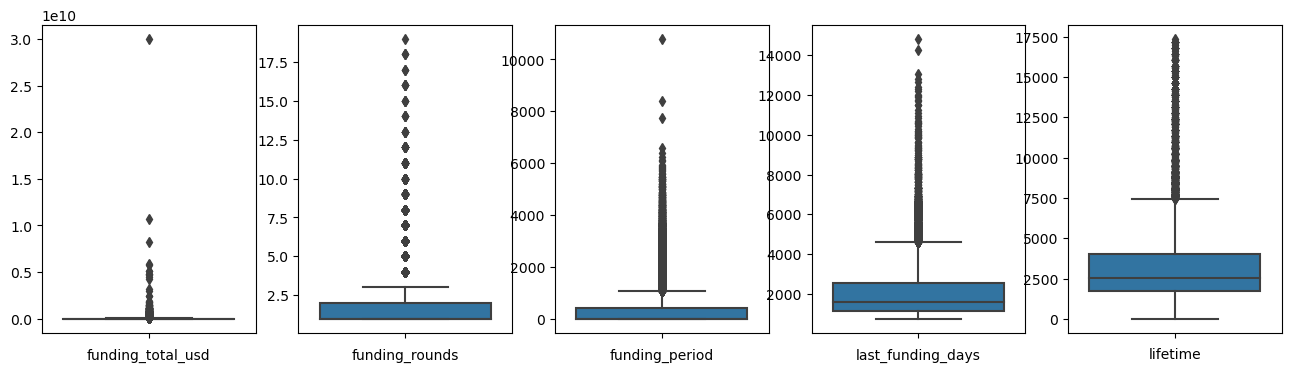

In [19]:
draw_boxplots(startups_train, ['funding_total_usd', 'funding_rounds', 'funding_period', 'last_funding_days', 'lifetime'], '')

<AxesSubplot:>

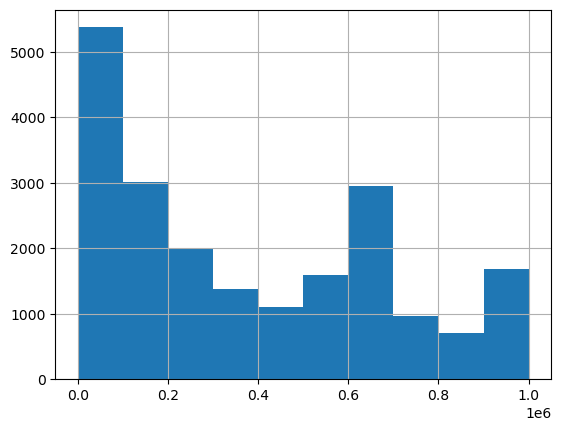

In [20]:
startups_train['funding_total_usd'].hist(range=[0, 1000000])

In [21]:
startups_train['funding_total_usd'].quantile(0.666)

4341998.879999997

In [22]:
low = startups_train['funding_total_usd'].quantile(0.333)
mid = startups_train['funding_total_usd'].quantile(0.666)

def funding_group(data):
    if data['funding_total_usd'] < low:
        return 'funding_low'
    if data['funding_total_usd'] < mid:
        return 'funding_mid'
    return 'funding_high' 

startups_train['funding_group'] = startups_train.apply(funding_group, axis=1)
startups_test['funding_group'] = startups_test.apply(funding_group, axis=1)

### Проверка на мультиколлинеарность

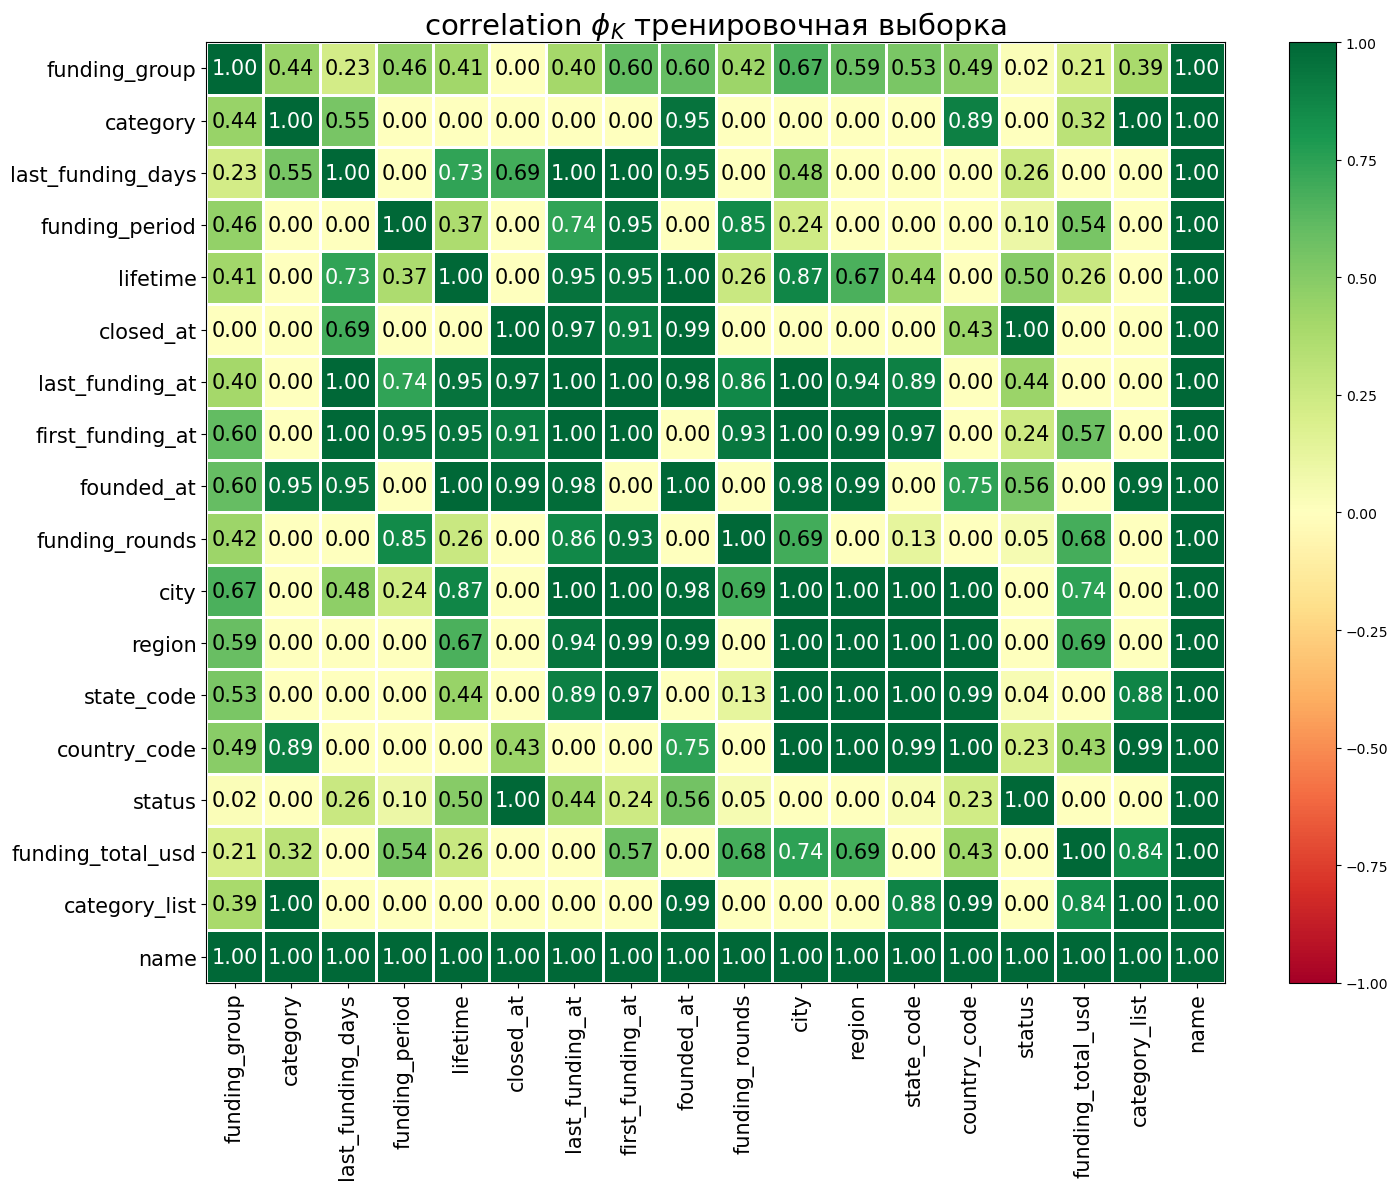

In [24]:
phik_overview = startups_train.sample(1000).phik_matrix(
    interval_cols=['funding_rounds', 'lifetime', 'last_funding_days', 'funding_period', 'funding_total_usd']
)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$ тренировочная выборка",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

Выберем не мультиколлинеарные признаки

In [25]:
ohe_columns = ['city', 'category']
ord_columns = ['funding_group']
num_columns = ['funding_rounds', 'lifetime', 'last_funding_days', 'funding_period', 'funding_total_usd']

### Подготовка пайплайна к обучению

In [26]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    startups_train[ohe_columns+ord_columns+num_columns],
    startups_train['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = startups_train['status'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39384, 8), (13129, 8), (39384,), (13129,))

In [28]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=True))
    ]
)

In [29]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['funding_low', 'funding_mid', 'funding_high'], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [30]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [33]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [34]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LGBMClassifier()
    {
        'models': [lgb.LGBMClassifier()],
        'models__num_leaves': range(20, 48),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

### Обучение моделей с помощью GridSearchCV

In [35]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.95092098 0.95092098 0.95092098 0.95090701
 0.95090701 0.95090701 0.95090701 0.95090701 0.95090701 0.95089304
 0.95089304 0.95089304 0.95089304 0.95089304 0.95089304 0.95086508
 0.95086508 0.95086508 0.95089304 0.95089304 0.95089304 0.95087906
 0.95087906 0.95087906 0.95092098 0.95090701 0.95090701 0.95089304
 0.95089304 0.95089304 0.95089303 0.95089303 0.95089303 0.95085111
 0.95085111 0.95085111 0.95087906 0.95087906 0.95

[LightGBM] [Info] Number of positive: 35699, number of negative: 3685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1976
[LightGBM] [Info] Number of data points in the train set: 39384, number of used features: 473
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.906434 -> initscore=2.270852
[LightGBM] [Info] Start training from score 2.270852
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                       

In [36]:
y_test_pred = grid_search.predict(X_test)

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [37]:
print(f"Метрика F1 score на тестовой выборке: {f1_score(y_test, y_test_pred)}")

Метрика F1 score на тестовой выборке: 0.9870811801966995


In [38]:
best_model = grid_search.best_estimator_.named_steps['models']
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

In [39]:
X_result = preprocessor.transform(startups_test[ohe_columns+ord_columns+num_columns])

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [40]:
predict_status = best_model.predict(X_result)

In [41]:
(
    pd.DataFrame({'name': startups_test['name'], 'status': label_encoder.inverse_transform(predict_status)})
      .to_csv('data/kaggle_startups.csv', index=False)
)

In [42]:
import shap
SAMPLE_COUNT = 20

In [43]:
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros


In [44]:
X_train_preprocessed_sample = shap.sample(X_train_preprocessed, SAMPLE_COUNT, random_state=RANDOM_STATE)
X_test_preprocessed_sample = shap.sample(X_test_preprocessed, SAMPLE_COUNT, random_state=RANDOM_STATE)

In [45]:
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_sample)
shap_values = explainer.shap_values(X_test_preprocessed_sample)

  0%|          | 0/20 [00:00<?, ?it/s]

Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.
Converting data to scipy sparse matrix.


In [46]:
features_names = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1]\
                            .named_steps['ohe'].get_feature_names_out(ohe_columns)

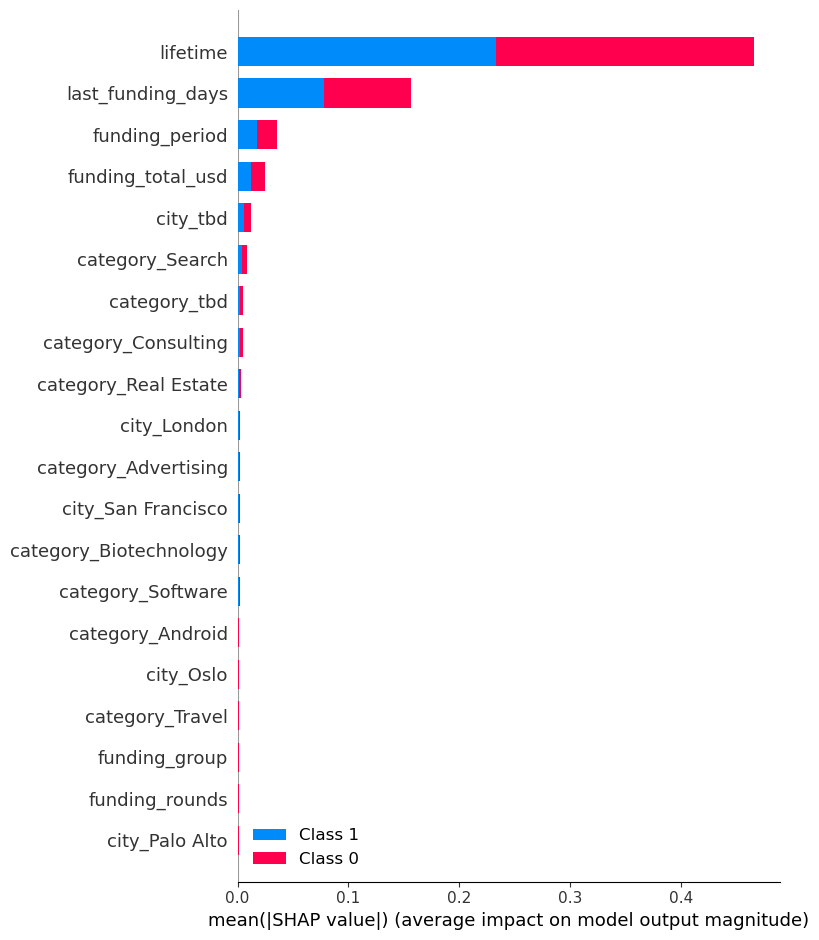

In [47]:
shap.summary_plot(shap_values, feature_names=list(features_names)+ord_columns+num_columns) 

## Вывод
Наилучшие показатели показала модель градиентного бустинга. Наиболее значимыми признаками являются время существования стартапа, время с последнего инвестирования, время с первого инвестирования до последнего и сумма инвестрования. Именно на эти параметры рекомендуется обратиь внимание при выборе стартапа.